In [1]:
import json
from Levenshtein import distance as levenshtein_distance
from sklearn.model_selection import train_test_split

import numpy as np
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import importlib

import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision.io import read_image
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, random_split, DataLoader

# sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '/home/dornika/OCR_Project')))
from Scripts import  Data_loader,Transforms
from Models import CRNN
import Scripts.Train as Train


/home/dornika/OCR_Project/OCR_env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### **0 move and extract data**

### **1 Preparing data for Train OCR model**

 1.1 Load DataFrame

In [2]:
# Open and read the JSON file
with open('char_to_index.json', 'r') as file:
    data = json.load(file)

# Print the data
# print(data["char_to_index"]["!"])
char_list = data["char_to_index_list"]
char_to_index = data["char_to_index"]
print(char_list)
print(char_to_index)

['!', '%', '(', ')', '*', '+', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', '«', '»', '،', '؛', '؟', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '\u200c', '“', '”', 'ء']
{'!': 1, '%': 2, '(': 3, ')': 4, '*': 5, '+': 6, '.': 7, '/': 8, '0': 9, '1': 10, '2': 11, '3': 12, '4': 13, '5': 14, '6': 15, '7': 16, '8': 17, '9': 18, ':': 19, '«': 20, '»': 21, '،': 22, '؛': 23, '؟': 24, 'ئ': 25, 'ا': 26, 'ب': 27, 'ت': 28, 'ث': 29, 'ج': 30, 'ح': 31, 'خ': 32, 'د': 33, 'ذ': 34, 'ر': 35, 'ز': 36, 'س': 37, 'ش': 38, 'ص': 39, 'ض': 40, 'ط': 41, 'ظ': 42, 'ع': 43, 'غ': 44, 'ف': 45, 'ق': 46, 'ل': 47, 'م': 48, 'ن': 49, 'ه': 50, 'و': 51, 'پ': 52, 'چ': 53, 'ژ': 54, 'ک': 55, 'گ': 56, 'ی': 57, '\u200c': 58, '“': 59, '”': 60, 'ء': 61}


In [3]:
gdf = pd.read_csv("Data/generated_data_40000.csv")
gdf = gdf.loc[:, ~gdf.columns.str.contains('^Unnamed')]
gdf = gdf[gdf['label'].str.len() < 15]
gdf.head(10)

,label,path
0,استوانهم,generated_data/g_0.png
1,باروحیه‌ترینش,generated_data/g_1.png
2,آسودیم,generated_data/g_2.png
3,بازه‌ای,generated_data/g_3.png
4,اشیأترینتان,generated_data/g_4.png
5,آمپرسنجهایی,generated_data/g_5.png
6,ارعابم,generated_data/g_6.png
7,ارتجاعی,generated_data/g_7.png
8,آدامسهایمان,generated_data/g_8.png
9,استخلاصت,generated_data/g_9.png


In [4]:
df = pd.read_csv("Data/train_df.csv")
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df[df['label'].str.len() < 15]
df = df[["label" , "path"]]
df.head(10)

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
5,ریزگردها,02250_87_77933.png
6,سالگذشته,06715_66_498681.png
7,هولناک,05562_35_186468.png
8,اباالحسن,06711_29_9457.png
9,مواردرا,02937_30_899678.png


In [5]:
tdf = pd.read_csv("Data/test_df.csv")
tdf = tdf.loc[:, ~tdf.columns.str.contains('^Unnamed')]
tdf = tdf[tdf['label'].str.len() < 15]
tdf = tdf[["label" , "path"]]
tdf.head(10)

,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تأثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
5,وفقط,04284_139_1015608.png
6,صحرایی,04558_156_35334.png
7,دریافت.,03445_105_141224.png
8,قطار,03051_25_39708.png
9,افشای,04444_74_37847.png


In [6]:
frames = [df, gdf]
df = pd.concat(frames)
df = df.reset_index(drop=True)
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
92502,اتوهایمان,generated_data/g_39993.png
92503,اسایه‌ای,generated_data/g_39995.png
92504,افضل,generated_data/g_39996.png
92505,اتمهایم,generated_data/g_39997.png


1.2 Convert image path as key and it's label as value of dictionary.

(32, 100)
(32, 100, 1)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


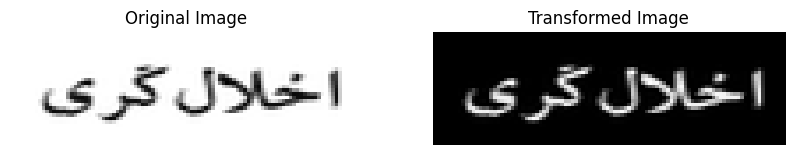

In [7]:


# Load grayscale image
image_path = 'Data/persian_unique_ocr_dataset/generated_data/g_14.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert to NumPy array
image_np = np.array(image)
print(image_np.shape)
image_np = np.expand_dims(image_np, axis=2)
print(image_np.shape)
# Apply transformations
transformed = Transforms.Training_transforms(image=image_np)
transformed_image = transformed['image']
print(transformed_image)
# Visualize the results
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')  # Squeeze for grayscale
plt.axis('off')

plt.show()


In [8]:
def find_longest_string(string_list):
  longest_string = ""
  for string in string_list:
    if len(string) > len(longest_string):
      longest_string = string
  return longest_string

In [9]:
def unique_chars_in_strings(string_list):
  """
  Finds the unique characters across a list of strings.

  Args:
    string_list: A list of strings.

  Returns:
    A set containing the unique characters found in the input strings.
  """
  unique_chars = set()
  for string in string_list:
    unique_chars.update(string)
  return unique_chars


In [10]:
# Assuming 'df' is your DataFrame and 'label' is the column containing the strings
rows_with_specific_char = df[df['label'].str.contains(' ', na=False)]
# pd.set_option('display.max_rows', df.shape[0]+1)
rows_with_specific_char

,label,path
55201,آر,generated_data/g_828.png
56711,سی,generated_data/g_2400.png
56981,سی,generated_data/g_2682.png
57214,دی,generated_data/g_2929.png
60005,دبلیو,generated_data/g_5845.png
60520,اچ,generated_data/g_6380.png
64841,دی,generated_data/g_10915.png
69360,دی,generated_data/g_15668.png
71620,پی,generated_data/g_18045.png
73264,اس,generated_data/g_19753.png


In [11]:
index_names = df[df['label'].str.contains(' ', na=False)].index
index_names

Index([55201, 56711, 56981, 57214, 60005, 60520, 64841, 69360, 71620, 73264,
       75679, 75919, 76907, 78322, 79304, 79397, 80513, 81315, 82716, 84689,
       84708, 85511, 87349, 89661],
      dtype='int64')

In [12]:
df = df.drop(index_names)
df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
92502,اتوهایمان,generated_data/g_39993.png
92503,اسایه‌ای,generated_data/g_39995.png
92504,افضل,generated_data/g_39996.png
92505,اتمهایم,generated_data/g_39997.png


In [14]:

df['label'] = df['label'].str.replace(r'[آأً]', 'ا', regex=True)  # Replace 'آ' and 'أ' with 'ا'
df['label'] = df['label'].str.replace(r'ؤ', 'و', regex=True)     # Remove 'ً'
df['label'] = df['label'].str.replace(r'ۀ', 'ه', regex=True)

df

,label,path
0,درکنار,04468_153_86244.png
1,4335,04335_0_275410.png
2,وتولد,05065_71_1234560.png
3,تراژدی‌ای,00459_42_782347.png
4,افزود:استفاده,02664_92_166182.png
...,...,...
92502,اتوهایمان,generated_data/g_39993.png
92503,اسایه‌ای,generated_data/g_39995.png
92504,افضل,generated_data/g_39996.png
92505,اتمهایم,generated_data/g_39997.png


In [15]:
unique_characters = unique_chars_in_strings(df['label'].tolist())
print(unique_characters)
print(len(unique_characters))

{'4', '/', 'ق', ')', 'ظ', 'ب', 'ژ', 'ک', '5', '»', 'ع', 'ج', 'ض', 'ر', 'ت', 'ص', '؟', '\u200c', 'ذ', 'ا', 'م', '6', 'ث', '!', '9', '*', 'س', 'ن', '(', 'پ', 'ط', 'ء', 'ئ', '2', '1', 'ی', 'و', '؛', 'د', '3', 'ه', '0', 'چ', '.', '”', 'ف', '%', '“', '،', 'غ', '7', 'ل', ':', 'ش', '«', 'ح', '8', 'ز', 'گ', 'خ', '+'}
61


In [16]:
tdf['label'] = tdf['label'].str.replace(r'[آأً]', 'ا', regex=True)  # Replace 'آ' and 'أ' with 'ا'
tdf['label'] = tdf['label'].str.replace(r'ؤ', 'و', regex=True)     # Remove 'ً'
tdf['label'] = tdf['label'].str.replace(r'ۀ', 'ه', regex=True)
unique_characters = unique_chars_in_strings(tdf['label'].tolist())
print(unique_characters)
print(len(unique_characters))
tdf

{'4', '/', 'ق', ')', 'ظ', 'ب', 'ژ', 'ک', '5', '»', 'ج', 'ض', 'ع', 'ر', 'ت', 'ص', '؟', '\u200c', 'م', 'ا', 'ث', '6', 'ذ', '!', '9', '*', 'س', 'ن', '(', 'پ', 'ط', 'ئ', '2', '1', 'ی', 'و', '؛', 'د', 'ه', '3', '0', 'چ', '.', 'ف', '“', '،', 'غ', '7', 'ل', 'ش', ':', '«', 'ح', '8', 'ز', 'گ', 'خ', '+'}
58


,label,path
0,اغماض،,04964_166_518242.png
1,مرجعیت,05210_164_648841.png
2,تاثر،,04692_131_543131.png
3,همکاریشیما,05069_183_579292.png
4,داستان‌نویس،,05066_145_652706.png
...,...,...
6079,سردتر,06188_142_90505.png
6080,القیاره،,01327_180_507718.png
6081,سرازیر,00151_25_299435.png
6082,الحسن,06711_51_9479.png


In [17]:
t = find_longest_string(df['label'].tolist())
print(t,len(t))

نیمه‌یارانه‌ای 14


In [18]:
dataset = df.set_index('path')['label'].to_dict()
print(len(dataset))
dict(list(dataset.items())[0:10])


92483


{'04468_153_86244.png': 'درکنار',
 '04335_0_275410.png': '4335',
 '05065_71_1234560.png': 'وتولد',
 '00459_42_782347.png': 'تراژدی\u200cای',
 '02664_92_166182.png': 'افزود:استفاده',
 '02250_87_77933.png': 'ریزگردها',
 '06715_66_498681.png': 'سالگذشته',
 '05562_35_186468.png': 'هولناک',
 '06711_29_9457.png': 'اباالحسن',
 '02937_30_899678.png': 'مواردرا'}

1.3 Custom Torch dataclass

In [19]:
tdataset = tdf.set_index('path')['label'].to_dict()
print(len(tdataset))
dict(list(tdataset.items())[0:10])


6053


{'04964_166_518242.png': 'اغماض،',
 '05210_164_648841.png': 'مرجعیت',
 '04692_131_543131.png': 'تاثر،',
 '05069_183_579292.png': 'همکاریشیما',
 '05066_145_652706.png': 'داستان\u200cنویس،',
 '04284_139_1015608.png': 'وفقط',
 '04558_156_35334.png': 'صحرایی',
 '03445_105_141224.png': 'دریافت.',
 '03051_25_39708.png': 'قطار',
 '04444_74_37847.png': 'افشای'}

1.4 Apply Data Augmentation and Preprocessing

1.5 Split data to Train, test and validation with proportion of 80%, 10% and 10% respectively.

In [20]:
img_dir = "Data/persian_unique_ocr_dataset"

In [22]:
import importlib
importlib.reload(Data_loader)

train_dataset = Data_loader.OCRDataset(img_dir,dataset , char_to_index , input_length=24,transform=Transforms.Training_transforms)
val_dataset = Data_loader.OCRDataset(img_dir,tdataset , char_to_index , input_length=24,transform=Transforms.Testing_transforms)

100%|██████████| 6053/6053 [00:00<00:00, 6260.62it/s]


In [23]:
train_dataset.__getitem__(1)

(tensor([[[0.8071, 0.8071, 0.8071,  ..., 0.8071, 0.8071, 0.8071],
          [0.8071, 0.8071, 0.8071,  ..., 0.8071, 0.8071, 0.8071],
          [0.8071, 0.8071, 0.8071,  ..., 0.8071, 0.8071, 0.8071],
          ...,
          [0.8065, 0.8066, 0.8069,  ..., 0.8071, 0.8071, 0.8071],
          [0.8049, 0.8053, 0.8063,  ..., 0.8071, 0.8071, 0.8071],
          [0.8039, 0.8045, 0.8060,  ..., 0.8071, 0.8071, 0.8071]]]),
 tensor([13, 12, 12, 14]),
 24,
 4)

In [24]:
def collate_fn(batch):
    """Custom collate function to handle variable-length sequences.

    Args:
        batch: A list of data samples, where each sample is a tuple
                of (image, label, length).

    Returns:
        A tuple containing:
            images: A batched tensor of images.
            labels: A padded tensor of labels.
            target_lengths: A tensor of label lengths.
    """
    images, labels, input_lengths, tagret_lengths = zip(*batch)

    # Pad the labels to the maximum length in the batch
    labels = pad_sequence([label.clone().detach() for label in labels], 
                    batch_first=True, padding_value=0)
    # Stack the images and lengths
    # images = images.tensor(images)
    images = torch.stack(images, 0)
    input_lengths = torch.tensor(input_lengths)
    tagret_lengths = torch.tensor(tagret_lengths)

    return images, labels, input_lengths, tagret_lengths

In [25]:
train_data = DataLoader(train_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn , num_workers= 4)
val_data = DataLoader(val_dataset, batch_size=1000, shuffle=True,  collate_fn=collate_fn, num_workers= 4)

In [26]:
# Assuming the CRNN class is already defined
num_classes = 62  # Adjust for Persian characters + numbers + punctuation + blank token
model = CRNN(num_classes=num_classes)
# Define CTC Loss and Optimizer
criterion = nn.CTCLoss(blank=0)  # 0 as the blank token index
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:

importlib.reload(Train)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = {"path": "Models/checkpoints/v0.01","log_path":"Logs", "metrics":["Train_Loss", "Val_Loss", "Train_CER", "Train_WER" ,"Val_CER", "Val_WER" , "Train_character_accuracy", "Train_word_accuracy", "Val_character_accuracy", "Val_word_accuracy"]}
plots = {"path": "Plots"}
train_CRNN = Train.Train(train_loader = train_data, val_loader = val_data, criterion=criterion, optimizer=optimizer, device = device, char_to_index=char_to_index, metrics=["character_accuracy", "word_accuracy", "WER", "CER"], num_epochs=150)
train_CRNN.fit(model=model,plots = plots, checkpoint= checkpoint)

KeyboardInterrupt: 

In [79]:
test = pd.read_csv("/content/test_df.csv")
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test.head(10)

,index,label,page,top_left_y,bot_right_y,top_left_x,bot_right_x,path
0,518242,اغماض،,4964,520,550,45,103,04964_166_518242.png
1,648841,مرجعیت,5210,645,675,203,260,05210_164_648841.png
2,543131,تأثر،,4692,610,640,428,462,04692_131_543131.png
3,579292,همکاریشیما,5069,625,655,45,129,05069_183_579292.png
4,652706,داستان‌نویس،,5066,520,550,199,295,05066_145_652706.png
5,1015608,وفقط,4284,450,480,227,264,04284_139_1015608.png
6,35334,صحرایی,4558,610,640,348,408,04558_156_35334.png
7,141224,دریافت.,3445,380,410,452,512,03445_105_141224.png
8,39708,قطار,3051,135,165,190,222,03051_25_39708.png
9,37847,افشای,4444,330,360,525,575,04444_74_37847.png


In [3]:
def ctc_decode(predictions, blank=0):
    """
    Decode predictions using CTC decoding.

    Args:
        predictions (Tensor): Model predictions.
        blank (int): Blank token index.

    Returns:
        list: Decoded text predictions.
    """
    pred_texts = []
    for pred in predictions:
        pred_chars = []
        previous_char = None
        for char in pred:
            if char != previous_char and char != blank:
                pred_chars.append(char)
            previous_char = char
        pred_texts.append(pred_chars)
    return pred_texts

In [ ]:
path = "Models/checkpoints/v0.01/best_model_Val_word_accuracy.pth"
device ="cuda"
checkpoint = torch.load(path)
model = CRNN(num_classes=62)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

/tmp/ipykernel_22616/3445367943.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 1), stride=(2, 1

In [14]:
val_data = DataLoader(val_dataset, batch_size=1000, shuffle=False,  collate_fn=collate_fn, num_workers= 4)

NameError: name 'val_dataset' is not defined

In [56]:
incorrect_cases =[]
device ="cuda"
for images, targets, input_lengths,target_lengths in val_data:
    images = images.to(device)
    model_output = model(images)
    model_output = model_output.permute(1, 0, 2)
    predictions = model_output.argmax(2).transpose(0, 1).cpu().numpy()
    decoded_predictions  = ctc_decode(predictions, blank=0)
    decoded_targets = []
    target_texts = [targets[i][:target_lengths[i]].tolist() for i in range(len(targets))]
    for target, length in zip(targets.cpu().numpy(), target_lengths.cpu().numpy()):
        decoded_targets.append("".join(list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in target[:length]))  # Replace `char_set` with your character set

    # Compare predictions with targets and store incorrect cases

    correct_words = 0
    for pred, target , image in zip(decoded_predictions, target_texts , images):
        if pred != target:
            incorrect_cases.append({
                "image": image.cpu(),  # Store the image tensor
                "prediction": "".join(list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in pred),
                "target": "".join(list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in target),
                "char_target": list(list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in target),
                "char_prediction": list(list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in pred)
            })
        

# Analyze or save incorrect cases for further debugging
print(len(incorrect_cases))
for case in incorrect_cases:
    print(f"Prediction: {case['prediction']}| {case['char_prediction']} | Target: {case['target']} | {case['char_target']}")
    # Visualize the image if needed
    # Example: Use matplotlib to display the image
    # plt.imshow(case['image'].squeeze(), cmap='gray')
    # plt.show()

430
Prediction: دریافت:.| ['د', 'ر', 'ی', 'ا', 'ف', 'ت', ':', '.'] | Target: دریافت. | ['د', 'ر', 'ی', 'ا', 'ف', 'ت', '.']
Prediction: اصولا| ['ا', 'ص', 'و', 'ل', 'ا'] | Target: اصولاا | ['ا', 'ص', 'و', 'ل', 'ا', 'ا']
Prediction: یزد،اظهار| ['ی', 'ز', 'د', '،', 'ا', 'ظ', 'ه', 'ا', 'ر'] | Target: یزد،‌اظهار | ['ی', 'ز', 'د', '،', '\u200c', 'ا', 'ظ', 'ه', 'ا', 'ر']
Prediction: فیلمنامه| ['ف', 'ی', 'ل', 'م', 'ن', 'ا', 'م', 'ه'] | Target: فیلمنامه‌ | ['ف', 'ی', 'ل', 'م', 'ن', 'ا', 'م', 'ه', '\u200c']
Prediction: ساخته‌| ['س', 'ا', 'خ', 'ت', 'ه', '\u200c'] | Target: ساخته | ['س', 'ا', 'خ', 'ت', 'ه']
Prediction: قرارد| ['ق', 'ر', 'ا', 'ر', 'د'] | Target: قراررد | ['ق', 'ر', 'ا', 'ر', 'ر', 'د']
Prediction: تامل‌رانگیزر| ['ت', 'ا', 'م', 'ل', '\u200c', 'ر', 'ا', 'ن', 'گ', 'ی', 'ز', 'ر'] | Target: تامل‌برانگیزتر | ['ت', 'ا', 'م', 'ل', '\u200c', 'ب', 'ر', 'ا', 'ن', 'گ', 'ی', 'ز', 'ت', 'ر']
Prediction: انتورپلژیک| ['ا', 'ن', 'ت', 'و', 'ر', 'پ', 'ل', 'ژ', 'ی', 'ک'] | Target: انتورپبلژیک | ['ا', 'ن'

(-0.5, 99.5, 31.5, -0.5)

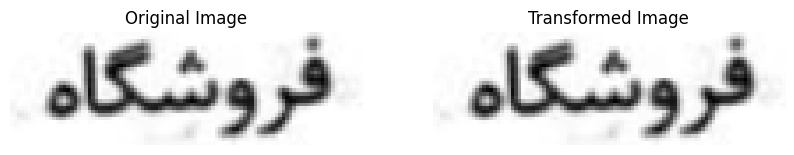

In [28]:
image_path = 'Data/page_1_118.png'
image = Image.open(image_path).convert('L')  # Convert to grayscale
# Convert to NumPy array
image_np = np.array(image)
# _, image_np = cv2.threshold(image_np, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
image_np = (image_np/255).astype('float32') 

image_np = np.expand_dims(image_np, axis=2)
transformed = Transforms.Testing_transforms(image=image_np)

transformed_image = transformed['image']
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_np, cmap='gray')
plt.axis('off')

# Transformed image
plt.subplot(1, 2, 2)
plt.title("Transformed Image")
plt.imshow(transformed_image.permute(1, 2, 0).squeeze().cpu().numpy(), cmap='gray')  # Squeeze for grayscale
plt.axis('off')

In [20]:
device ="cuda"
model_input = transformed_image.unsqueeze(0)
x = model_input.to(device)

model_output = model(x)
model_output
model_output = model_output.permute(1, 0, 2)
predictions = model_output.argmax(2).transpose(0, 1).cpu().numpy()

print(predictions)
predictions = ctc_decode(predictions, blank=0)

[[45 35 35 35 51 51 38 38 38 38 56 56 56 26 26 26  0  0  0  0  0  0  0 50]]


In [21]:
predictions

[[45, 35, 51, 38, 56, 26, 50]]

In [22]:
text_output = [list(char_to_index.keys())[list(char_to_index.values()).index(index)] for index in predictions[0] ]
text_output

['ف', 'ر', 'و', 'ش', 'گ', 'ا', 'ه']

In [21]:
torch.cuda.empty_cache()